# Gradient verification for the 1D diffusion case with 1st order kinetics

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
import copy
import logging
import os
from pathlib import Path
from typing import Iterable, List

import gstools as gs
import matplotlib.pyplot as plt
import nested_grid_plotter as ngp
import numpy as np
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import scipy as sp
from IPython.display import HTML
from matplotlib.animation import HTMLWriter
from pyrtid.utils import (
    NDArrayFloat,
    gen_random_ensemble,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Set-up logging level

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("this is a logging test")

INFO:root:this is a logging test


- Check package/software versions

In [3]:
pyrtid.utils.show_versions()

INFO:root:Current version = 0.1.2

INFO:root:Used packages version:

INFO:root:iterative_ensemble_smoother = 0.1.1
INFO:root:gstools                     = 1.5.1
INFO:root:matplotlib                  = 3.7.2
INFO:root:nested_grid_plotter         = 1.0.0
INFO:root:numdiftools                 = 0.9.41
INFO:root:numpy                       = 1.25.2
INFO:root:pyesmda                     = 0.4.3
INFO:root:pypcga                      = 0.1.0
INFO:root:scipy                       = 1.10.1
INFO:root:sksparse                    = 0.4.12
INFO:root:stochopy                    = 2.3.0


- Create a directory to store the exported figures

In [4]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [5]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    # "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [6]:
# Geometry
nx = 40  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 5.9  # voxel dimension along the x axis
dy = 9.26  # voxel dimension along the y axis
dz = 1.62  # voxel dimension along the z axis

# Time
duration_in_d = 10  # duration in days
duration_in_s = duration_in_d * 3600 * 24
dt_init = 3600 * 3  # timestep in seconds
dt_max = dt_init * 2
dt_min = dt_init / 2

# Geochem and others
c0 = 0.0  # general initial cocentration
c1 = 1e-3
# Hydro parameters
D0 = 1e-4  # general initial diffusion coefficient [m2/s] -> very strong here
k0 = 1e-30  # general permeability
w0 = 1.0  # general porosity [fraction]
# Chemistry parameters
M0 = 0.001  # mineral grade [mol/kg] -> kg of water
kv = -1e-4  # kinetic rate,       [mol/m2/s]
moleweight = 270.0  # molar weight [g/mol]
surface = 500  # cm2/g
As = moleweight * surface / 1e4  # specific area [m2/mol]
logK = 2
Ks = 1.0 / pow(10, logK)  # solubility constant [no unit]

stocoef = 5.0
crank_diff = 0.85

# Values for the x axis ()meters
x_positions_in_meters = np.arange(nx) * dx + dx / 2

- Five observation wells

In [7]:
observation_locations: List[int] = [4, 12, 20, 28, 36]

The mineral grades are defined in [mol/kg]. We calculate the conversion factor to obtain ppm and perform easier mass balances.

ConvU: parameter for converting the mineral content in [mol/kg] to metal grade in [ppm]. Note that the ConvU parameter is specific to the Uranium carrier phase: here Uraninite.

$C_{Uraninite}[\frac{mol}{kg}] = convU \times T_{Uranium}[ppm]$


and


$conv_u = \frac{1.023 \times density_{rock}}{238*porosity_{rock} \times 1000}$

Note the 1.023 is the conversion factor from molar mass to molal mass in CHESS.

In [8]:
conv_u: float = 1.023 * 1.63 / (238.0 * w0 * 1000)
logging.info(f"conv_u = {conv_u:.4e}")

INFO:root:conv_u = 7.0063e-06


- Create an initial gaussian spatial distribution for the mineral

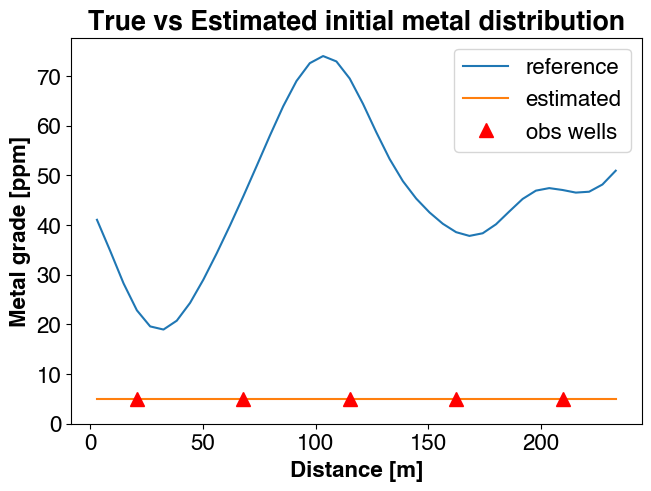

In [9]:
# Create a Gaussian Covariance Model just for the example
# To vary the results, change the seed :)
seed = 6
min_val = 10 * conv_u  # 10 ppm
max_val = 100 * conv_u  # 100 ppm
# Compute the mean and the standard deviation that the distribution should have so that
# <99% of the values are between min and max ~ 6 sigmas
mean = (max_val + min_val) / 2
stdev = (max_val - min_val) / 3 / 2  # std ~ 1/6 of the distribution interval
len_scale = 5

init_grade_reference = gen_random_ensemble(
    model=gs.covmodel.Gaussian,
    n_ensemble=1,
    var=stdev**2,
    len_scale=len_scale,
    mean=mean,
    nx=nx,
    ny=ny,
    seed=seed,
)[0, :, :, 0]


init_grade_reference = np.abs(init_grade_reference)
# Initial estimate = an homogeneous value
# 20
init_grade_estimate = np.ones((nx, ny)) * 5 * conv_u  # 25 ppm

plotter = ngp.NestedGridPlotter()
ax = plotter.ax_dict["ax1-1"]

ax.set_xlabel("Distance [m]", fontweight="bold")
ax.set_ylabel("Metal grade [ppm]", fontweight="bold")
ax.set_ylim(
    0.0, float(np.max((init_grade_estimate, init_grade_reference))) / conv_u * 1.05
)
ax.set_title("True vs Estimated initial metal distribution", fontweight="bold")
plotter.fig.set_facecolor("w")


ax.plot(x_positions_in_meters, init_grade_reference / conv_u, label="reference")
ax.plot(x_positions_in_meters, init_grade_estimate / conv_u, label="estimated")

# Add some vertical lines to indicate the well
for well_pos in observation_locations:
    ax.plot(
        well_pos * dx - dx / 2,
        np.mean(init_grade_estimate) / conv_u,
        label="obs wells",
        marker="^",
        markersize=10,
        c="r",
        linestyle="none",
    )

plotter.add_axis_legend("ax1-1")

fname = "true_vs_estimated_initial_mineral_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Note: The initial concentration is null.

### Forward problem in demonstrator

In [10]:
time_params = dmfwd.TimeParameters(
    duration=duration_in_s, dt_init=dt_init, dt_max=dt_max, dt_min=dt_min
)
geometry = dmfwd.Geometry(nx=nx, ny=ny, dx=dx, dy=dx, dz=dz)
fl_params = dmfwd.FlowParameters(k0)
tr_params = dmfwd.TransportParameters(
    diffusion=D0,
    porosity=w0,
    crank_nicolson_diffusion=crank_diff,
    fpi_eps=1e-12,
    is_numerical_acceleration=True,
)
gch_params = dmfwd.GeochemicalParameters(
    conc=c0, conc2=c1, grade=M0, kv=kv, As=As, Ks=Ks, stocoef=stocoef
)


# We define a function to easily generate a model.
def create_base_model() -> dmfwd.ForwardModel:
    return dmfwd.ForwardModel(geometry, time_params, fl_params, tr_params, gch_params)

- Create two models

In [11]:
init_grade_reference

array([[0.00028758],
       [0.00024348],
       [0.00019785],
       [0.00015995],
       [0.00013723],
       [0.00013281],
       [0.0001453 ],
       [0.00017038],
       [0.00020322],
       [0.00024021],
       [0.00027954],
       [0.00032063],
       [0.0003632 ],
       [0.00040629],
       [0.0004476 ],
       [0.00048327],
       [0.00050844],
       [0.00051849],
       [0.00051091],
       [0.0004868 ],
       [0.00045111],
       [0.00041103],
       [0.00037335],
       [0.00034204],
       [0.0003175 ],
       [0.00029798],
       [0.000282  ],
       [0.00027013],
       [0.00026486],
       [0.00026858],
       [0.00028125],
       [0.00029933],
       [0.00031696],
       [0.0003287 ],
       [0.00033226],
       [0.00032961],
       [0.00032593],
       [0.00032716],
       [0.00033734],
       [0.00035683]])

In [12]:
model_reference = create_base_model()
model_estimate = create_base_model()
# Exact initialmineral grade
model_reference.tr_model.set_initial_grade(init_grade_reference)
# Estimated initial mineral grade
model_estimate.tr_model.set_initial_grade(init_grade_estimate)

- Run the models

In [13]:
solver_reference = dmfwd.ForwardSolver(model_reference)
solver_reference.solve(is_verbose=False)

solver_estimate = dmfwd.ForwardSolver(model_estimate)
solver_estimate.solve()

- Top view of the forward concentrations

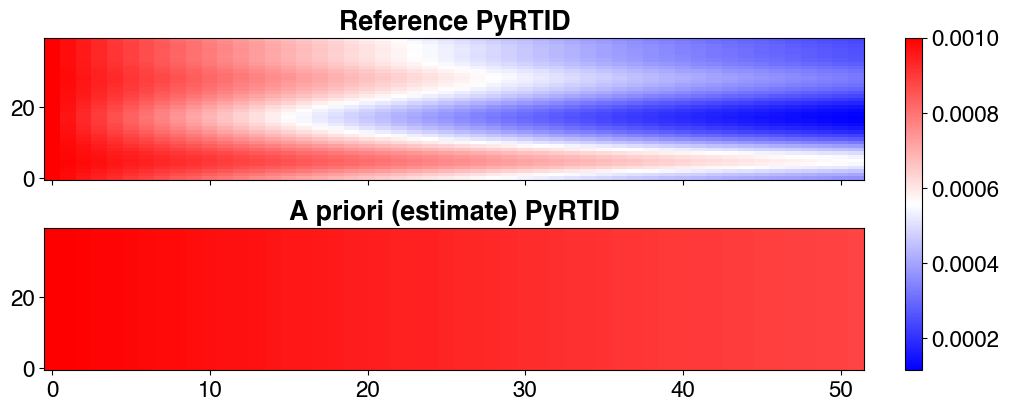

In [14]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 4)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Reference PyRTID": model_reference.tr_model.conc2[:, 0, :].T,
        "A priori (estimate) PyRTID": model_estimate.tr_model.conc2[:, 0, :].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Forward variables at the producer locations

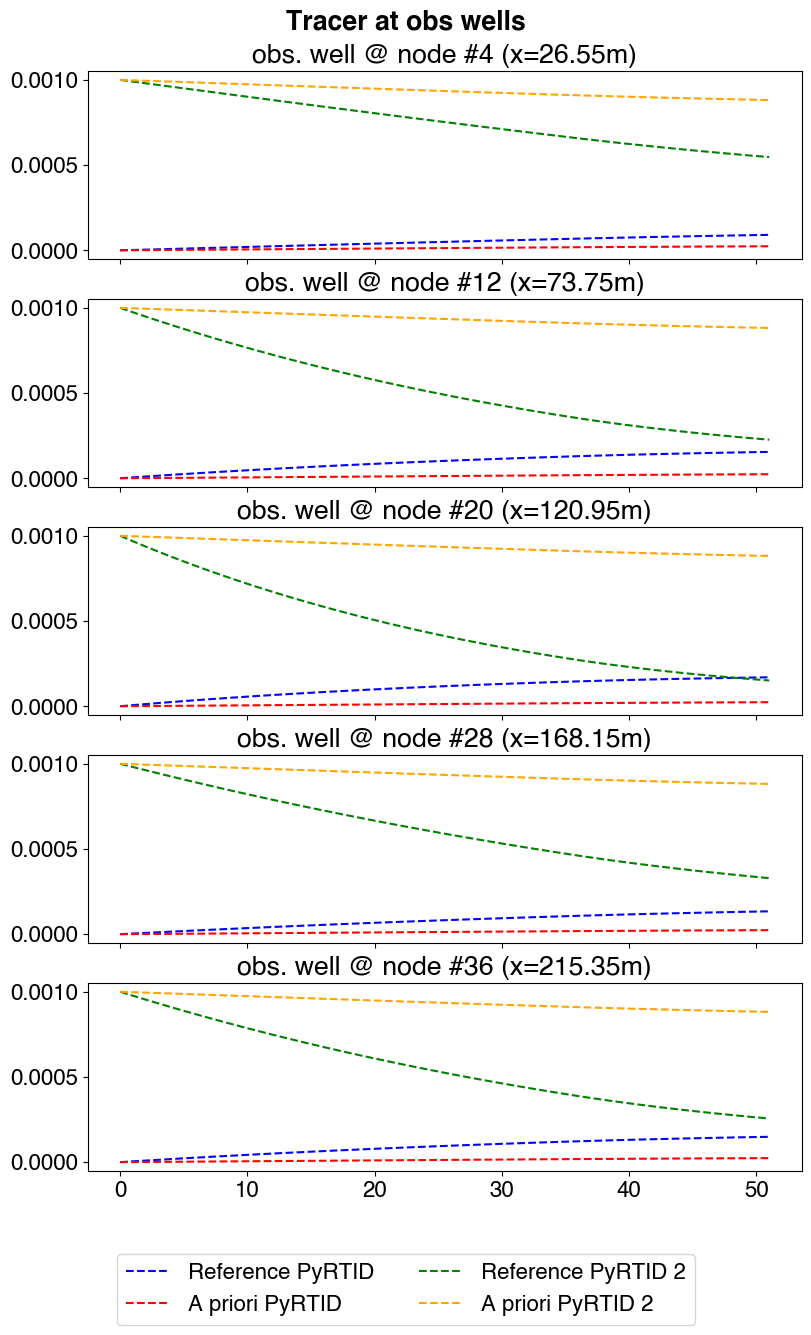

In [15]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"], ["ax5-1"]],
            sharey=False,
            sharex=True,
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * geometry.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x:.2f}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        model_reference.tr_model.conc[node_id, 0, :],
        label="Reference PyRTID",
        c="b",
        linestyle="--",
    )
    ax.plot(
        model_estimate.tr_model.conc[node_id, 0, :],
        label="A priori PyRTID",
        c="r",
        linestyle="--",
    )
    ax.plot(
        model_reference.tr_model.conc2[node_id, 0, :],
        label="Reference PyRTID 2",
        c="g",
        linestyle="--",
    )
    ax.plot(
        model_estimate.tr_model.conc2[node_id, 0, :],
        label="A priori PyRTID 2",
        c="orange",
        linestyle="--",
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [16]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 4)},
    subfigs_params={"nrows": 1},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=False, sharex=True),
    },
)

# Static plot
for ax_name in ["ax1-1"]:
    plotter.get_axis(ax_name).plot(
        model_reference.tr_model.conc[:, 0, 0] * 1e3, label="Initial", c="red"
    )

# Animated plot
nb_frames = min(model_reference.time_params.nt, 30)

plotter.animated_multi_plot(
    ax_name="ax1-1",
    nb_frames=nb_frames,
    data={
        "Reference": {
            "y": model_reference.tr_model.conc[:, 0, :] * 1e3,
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.conc[:, 0, :] * 1e3,
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    title="PyRTID",
    xlabel="Node #",
)
plotter.animated_multi_plot(
    ax_name="ax1-2",
    nb_frames=nb_frames,
    data={
        "Reference": {
            "y": model_reference.tr_model.grade[:, 0, :] * 1e3,
            "kwargs": {"c": "blue"},
        },
        "Estimated": {
            "y": model_estimate.tr_model.grade[:, 0, :] * 1e3,
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    title="PyRTID",
    xlabel="Node #",
    ylabel="[mmol/kg]",
)


for ax_name in plotter.ax_dict.keys():
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        plotter.ax_dict[ax_name].plot(
            well_pos,
            0.0002,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.add_axis_legend(ax_name)

plotter.subfigs["fig0"].suptitle("Concentration evolution", fontweight="bold")
# plotter.subfigs["fig1"].suptitle("Mineral grade evolution", fontweight="bold")

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(str(fname_html), writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Inversion

- Create a function to add some noise to the observations

In [17]:
freq_measure_in_d = 2  # one measure every two days
n_sampled_days = duration_in_d / freq_measure_in_d

obs_times_in_s = np.arange(n_sampled_days) * 3600 * 24 * freq_measure_in_d
obs_times_in_s

array([     0., 172800., 345600., 518400., 691200.])

In [18]:
noise_std: float = 5e-7  # This is an absolute value


def get_white_noise(shape: Iterable[int]) -> NDArrayFloat:
    """
    Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return np.random.default_rng(2021).normal(
        mean_noise, noise_std, size=np.array(shape)
    )


# Generate a white noise
obs_noise: NDArrayFloat = get_white_noise(
    (len(observation_locations), obs_times_in_s.size)
)

- Check the intensity of the noise

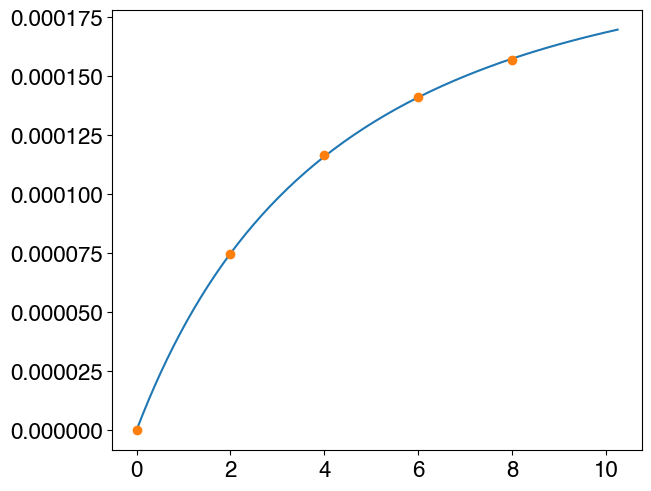

In [19]:
all_times = model_estimate.time_params.times

obs_values = np.zeros((len(observation_locations), obs_times_in_s.size))

for count, ix in enumerate(observation_locations):
    # interpolate the values
    obs_values[count] = (
        sp.interpolate.interp1d(
            all_times, model_reference.tr_model.conc[ix, 0, :], kind="cubic"
        )(obs_times_in_s)
        + obs_noise[count, :]
    )

count = 2

ix = observation_locations[count]
plt.plot(all_times / 3600 / 24, model_reference.tr_model.conc[ix, 0, :])
plt.plot(
    obs_times_in_s / 3600 / 24,
    obs_values[count],
    marker="o",
    linestyle="none",
)

### Demonstrator


- Check the correctness of the gradient

In [20]:
param = dminv.AdjustableParameter(
    name=dminv.ParameterName.INITIAL_GRADE,
    lbounds=1e-10,
    ubounds=1e-2,
    sp=0,
    preconditioner=dminv.SqrtTransform(),
)

observables = []
for i, node_id in enumerate(observation_locations):
    # Careful not to forget the x2
    observables.append(
        pyrtid.inverse.Observable(
            state_variable=pyrtid.inverse.StateVariable.CONCENTRATION,
            node_indices=node_id,
            times=obs_times_in_s,
            values=obs_values[i],
            uncertainties=noise_std,
            sp=0,
        )
    )

# Add grade observations in two places
# Commented for now because otherwise we don't see the other gradient.
# sampled_nodes = [3, 12]
# ix, iy, iz = node_number_to_indices(sampled_nodes)
# observables.append(
#     pyrtid.inverse.Observable(
#         state_variable=pyrtid.inverse.StateVariable.GRADE,
#         node_indices=sampled_nodes,
#         times=np.zeros(len(sampled_nodes)),
#         values=model_reference.tr_model.grade[ix, iy, 0],
#         uncertainties=float(np.min(init_grade_reference) * 0.1),
#     )
# )

# Create an executor to keep track of the adjoint model
solver_config = pyrtid.inverse.ScipySolverConfig(
    solver_name="L-BFGS-B",
    solver_options={"maxfun": 20, "maxiter": 20, "ftol": 1e-4, "gtol": 1e-4},
    is_check_gradient=False,
    is_adj_numerical_acceleration=True,
    afpi_eps=1e-15,
)
model_adjusted = copy.deepcopy(model_estimate)
inverse_model = pyrtid.inverse.InverseModel(param, observables)
executor = pyrtid.inverse.ScipyInversionExecutor(
    model_adjusted, inverse_model, solver_config
)

# Compute a first objective function
executor.eval_scaled_loss(param.preconditioner(param.values))

is_grad_ok = executor.is_adjoint_gradient_correct(max_workers=4, is_verbose=False)

INFO:root:- Running forward model # 1


INFO:root:- Run # 1 over
INFO:root:Loss (obs fit)        = 11896.186110133864
INFO:root:Loss (regularization) = 0.0
INFO:root:Regularization weight = 0.0
INFO:root:Scaling factor        = 8.406055442829209e-05
INFO:root:Loss (scaled)         = 1.0



In [ ]:
logging.info(f"Is the gradient correct: {is_grad_ok}")

INFO:root:Is the gradient correct: True


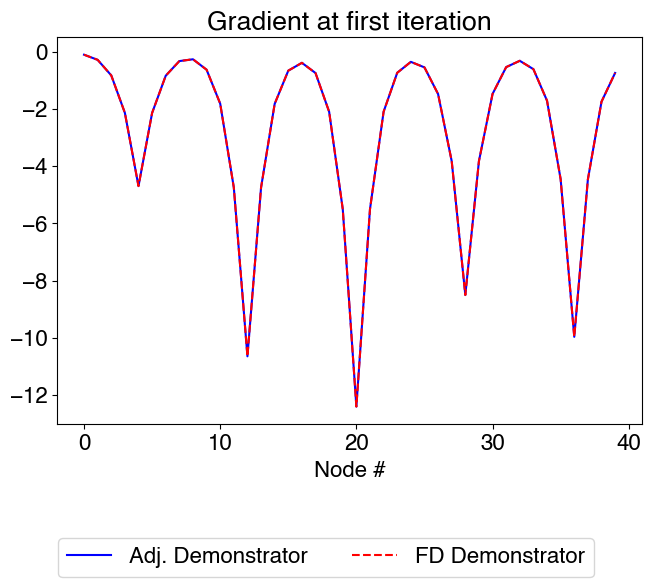

In [ ]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()

ax = plotter.get_axis("ax1-1")
ax.plot(
    param.grad_adj_history[0] * executor.inv_model.scaling_factor,
    label="Adj. Demonstrator",
    c="b",
)
ax.plot(
    param.grad_fd_history[0] * executor.inv_model.scaling_factor,
    label="FD Demonstrator",
    c="r",
    linestyle="--",
)
# ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g")
# ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")

ax.set_title("Gradient at first iteration")
ax.set_xlabel("Node #")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
param.grad_adj_history[0].shape

(40, 1)

In [ ]:
param.grad_fd_history[0].shape

(40, 1)

In [ ]:
param.grad_adj_history[0] - param.grad_fd_history[0]

array([[-3.05266008e-05],
       [-9.73898509e-05],
       [-1.26007671e-04],
       [-1.46947667e-04],
       [-1.00736710e-04],
       [-8.35521387e-05],
       [-1.60458085e-04],
       [-2.80940394e-05],
       [-2.27501527e-04],
       [-5.45640760e-05],
       [-8.11568752e-05],
       [-9.53123963e-05],
       [ 3.27649468e-06],
       [ 9.42070619e-05],
       [-1.45634094e-04],
       [-5.05636071e-05],
       [ 2.35951029e-05],
       [ 3.56680648e-05],
       [-9.70721740e-05],
       [ 1.39129006e-04],
       [ 9.69593239e-05],
       [ 1.36639937e-05],
       [ 3.27849848e-05],
       [-1.33771064e-05],
       [ 7.81594717e-05],
       [ 1.07258229e-05],
       [-5.17994085e-05],
       [ 2.26530756e-05],
       [-1.26550003e-05],
       [ 5.55360311e-05],
       [-7.02617399e-05],
       [ 3.66578834e-05],
       [ 8.85151367e-05],
       [ 2.07966787e-05],
       [ 7.76299494e-05],
       [-1.07051223e-04],
       [-2.10753497e-05],
       [-8.54359532e-05],
       [ 6.1

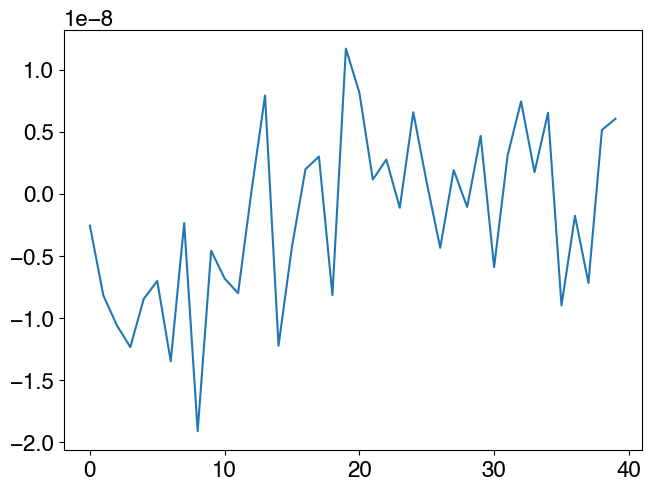

In [ ]:
plt.plot(
    (param.grad_adj_history[0] - param.grad_fd_history[0])
    * executor.inv_model.scaling_factor
)

In [ ]:
param.grad_adj_history[0] / param.grad_fd_history[0]

array([[1.00000002],
       [1.00000003],
       [1.00000001],
       [1.00000001],
       [1.        ],
       [1.        ],
       [1.00000002],
       [1.00000001],
       [1.00000007],
       [1.00000001],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.00000001],
       [1.00000001],
       [0.99999999],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999998],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999999],
       [0.99999998],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [0.99999999]])